In [1]:
import torch
from torch_geometric.data import Data
from torch_geometric.utils import k_hop_subgraph, to_undirected
import numpy as np

# ===== 1. 原始图与节点特征 =====
edge_index = torch.tensor([
    [0, 0, 1, 2, 3, 4],
    [1, 2, 2, 3, 4, 5]
], dtype=torch.long)
edge_index  = to_undirected(edge_index)
num_nodes = 6

# 随机初始化节点特征(比如embedding)，这里假设每个节点是4维embedding
embedding_dim = 4
torch.manual_seed(42)
node_emb = torch.randn(num_nodes, embedding_dim)

data = Data(x=node_emb, edge_index=edge_index)
print(data)

# ===== 2. k-hop子图采样 =====
src, dst = 2, 3
num_hops = 1
sub_node_index, sub_edge_index, mapping, _ = k_hop_subgraph(
    [src, dst], num_hops, data.edge_index, relabel_nodes=True
)

print("原图节点编号:", list(range(num_nodes)))
print("子图内节点对应原图编号:", sub_node_index.tolist())
print("src, dst 在子图的编号:", mapping.tolist())

# ===== 3. 子图节点 embedding =====
sub_x = data.x[sub_node_index]  # shape: [子图节点数, embedding_dim]
sub_src, sub_dst = mapping.tolist()

# ===== 4. 构建候选节点列表（不含src, dst）=====
candidates = [i for i in range(len(sub_node_index)) if i != sub_src and i != sub_dst]
print("候选节点（子图编号）:", candidates)

# ===== 5. 假定分数: 用 embedding 随机打分（可自定义复杂逻辑）=====
# 这里简单模拟，直接用 embedding 第一维度+少量噪声
np.random.seed(0)
scores = sub_x[candidates, 0] + torch.tensor(np.random.rand(len(candidates)))
print("候选节点分数:", scores.tolist())

# ===== 6. 选 top-k =====
top_k = 2
topk_indices = torch.topk(scores, top_k).indices.tolist()
topk_neighbors = [candidates[i] for i in topk_indices]
print("Top-k选中节点（子图编号）:", topk_neighbors)

# ===== 7. 汇总最终节点，重新编号 =====
final_nodes = [sub_src, sub_dst] + topk_neighbors
final_nodes = list(set(final_nodes))
final_nodes.sort()
print("最终节点（子图编号）:", final_nodes)

# 旧编号到新编号映射
node_id_map = {old: new for new, old in enumerate(final_nodes)}

# ===== 8. 得到最终 embedding =====
final_x = sub_x[final_nodes]
print("最终节点 embedding:")
print(final_x)

# ===== 9. 只保留最终节点间的边，重编号 =====
mask = torch.isin(sub_edge_index[0], torch.tensor(final_nodes)) & \
       torch.isin(sub_edge_index[1], torch.tensor(final_nodes))
final_edge_index = sub_edge_index[:, mask]
final_edge_index = torch.stack([
    torch.tensor([node_id_map[int(i)] for i in final_edge_index[0]]),
    torch.tensor([node_id_map[int(i)] for i in final_edge_index[1]])
], dim=0)
print("最终子图边:", final_edge_index.tolist())

src_new = node_id_map[sub_src]
dst_new = node_id_map[sub_dst]
print(src_new, dst_new)

# ===== 10. 输出最终 Data 对象（如需要可直接传入GNN）=====
final_data = Data(x=final_x, edge_index=final_edge_index)
print(final_data)


Data(x=[6, 4], edge_index=[2, 12])
原图节点编号: [0, 1, 2, 3, 4, 5]
子图内节点对应原图编号: [0, 1, 2, 3, 4]
src, dst 在子图的编号: [2, 3]
候选节点（子图编号）: [0, 1, 4]
候选节点分数: [2.4757287918988213, 1.393607764275862, 0.2930366013791085]
Top-k选中节点（子图编号）: [0, 1]
最终节点（子图编号）: [0, 1, 2, 3]
最终节点 embedding:
tensor([[ 1.9269,  1.4873,  0.9007, -2.1055],
        [ 0.6784, -1.2345, -0.0431, -1.6047],
        [ 0.3559, -0.6866, -0.4934,  0.2415],
        [-1.1109,  0.0915, -2.3169, -0.2168]])
最终子图边: [[0, 0, 1, 1, 2, 2, 2, 3], [1, 2, 0, 2, 0, 1, 3, 2]]
2 3
Data(x=[4, 4], edge_index=[2, 8])


In [33]:
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import torch

data_tuple = torch.load('../ScoreSample-SEAL/data/Cora/processed/data.pt')

# 提取第一个元素（字典）
data_dict = data_tuple[0]

# 从字典构造PyG的Data对象
data = Data(
    x=data_dict['x'],
    edge_index=data_dict['edge_index'],
    y=data_dict['y'],
    train_mask=data_dict.get('train_mask'),
    val_mask=data_dict.get('val_mask'),
    test_mask=data_dict.get('test_mask')
)

print(data)
print(data.edge_index.size(1) / data.x.size(0))
# 构建NetworkX图
G = nx.Graph()
G.add_nodes_from(range(data.num_nodes))
edge_index = data.edge_index.cpu().numpy()
edges = list(zip(edge_index[0], edge_index[1]))
G.add_edges_from(edges)



Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
3.8980797636632203


In [25]:
# no isolated nodes
isolated_nodes = [node for node, degree in G.degree() if degree == 0]
print("Number of isolated nodes:", len(isolated_nodes))

# no selfloops
num_selfloops = nx.number_of_selfloops(G)
print("Number of selfloops:", num_selfloops)

# the graph is fully connected
num_components = nx.number_connected_components(G)
print("Number of connected components:", num_components)

Number of isolated nodes: 0
Number of selfloops: 0
Number of connected components: 78


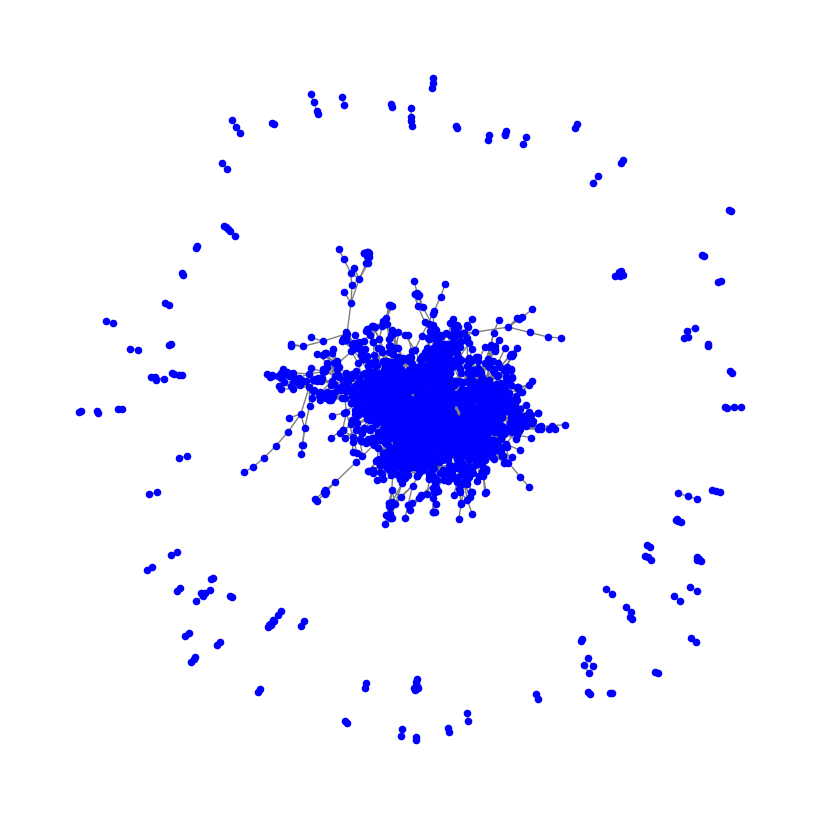

In [26]:
# 绘图
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, node_size=20, node_color='blue', edge_color='gray')
plt.show()

In [28]:
import torch

def test_topk_selection():
    device = 'cpu'  # 测试用CPU

    # 模拟子图节点数（包括 src 和 dst）
    num_nodes = 10
    src = 3
    dst = 7

    # 候选节点（除去 src 和 dst）
    candidates = [i for i in range(num_nodes) if i != src and i != dst]
    candidates_tensor = torch.tensor(candidates, device=device, dtype=torch.long)

    # 模拟对应的得分（随便生成，保证每个候选有一个分数）
    # 这里用随机数模拟分数，种子固定，方便复现
    torch.manual_seed(42)
    scores = torch.rand(len(candidates), device=device)

    # 取 top 3 节点
    k_top = 3
    topk_scores, topk_indices = torch.topk(scores, k_top)

    topk_neighbors = candidates_tensor[topk_indices].tolist()

    print("Candidates (节点编号):", candidates)
    print("Scores:", scores.tolist())
    print("Top-k Scores:", topk_scores.tolist())
    print("Top-k Indices in scores tensor:", topk_indices.tolist())
    print("Top-k Neighbor Node IDs:", topk_neighbors)

test_topk_selection()


Candidates (节点编号): [0, 1, 2, 4, 5, 6, 8, 9]
Scores: [0.8822692632675171, 0.9150039553642273, 0.38286375999450684, 0.9593056440353394, 0.3904482126235962, 0.600895345211029, 0.2565724849700928, 0.7936413288116455]
Top-k Scores: [0.9593056440353394, 0.9150039553642273, 0.8822692632675171]
Top-k Indices in scores tensor: [3, 1, 0]
Top-k Neighbor Node IDs: [4, 1, 0]


In [6]:
import torch
import numpy as np
from torch_geometric.utils import to_scipy_sparse_matrix, k_hop_subgraph, to_undirected
from scipy.sparse.csgraph import shortest_path

# 随机一个小的图用于测试（示例）
edge_index = torch.tensor([[0, 1, 2, 3, 3, 6],
                            [1, 0, 3, 2, 4, 5]], dtype=torch.long)
edge_index = to_undirected(edge_index)
src, dst = 5, 4
num_nodes = 7

def drnl_node_labeling_old(edge_index, src, dst, num_nodes=None):
    src, dst = (dst, src) if src > dst else (src, dst)
    adj = to_scipy_sparse_matrix(edge_index, num_nodes=num_nodes).tocsr()

    idx = list(range(src)) + list(range(src + 1, adj.shape[0]))
    adj_wo_src = adj[idx, :][:, idx]

    idx = list(range(dst)) + list(range(dst + 1, adj.shape[0]))
    adj_wo_dst = adj[idx, :][:, idx]

    dist2src = shortest_path(adj_wo_dst, directed=False, unweighted=True, indices=src)
    dist2src = np.insert(dist2src, dst, 0, axis=0)
    dist2src = torch.from_numpy(dist2src)

    dist2dst = shortest_path(adj_wo_src, directed=False, unweighted=True, indices=dst - 1)
    dist2dst = np.insert(dist2dst, src, 0, axis=0)
    dist2dst = torch.from_numpy(dist2dst)

    dist = dist2src + dist2dst
    dist_over_2, dist_mod_2 = dist // 2, dist % 2

    z = 1 + torch.min(dist2src, dist2dst)
    z += dist_over_2 * (dist_over_2 + dist_mod_2 - 1)
    z[src] = 1.
    z[dst] = 1.
    z[torch.isnan(z)] = 0.

    return z.to(torch.long)

def drnl_node_labeling_fixed(edge_index, src, dst, num_nodes=None):
    src, dst = (dst, src) if src > dst else (src, dst)
    adj = to_scipy_sparse_matrix(edge_index, num_nodes=num_nodes).tocsr()

    idx_wo_src = list(range(adj.shape[0]))
    idx_wo_src.pop(src)
    adj_wo_src = adj[idx_wo_src, :][:, idx_wo_src]

    idx_wo_dst = list(range(adj.shape[0]))
    idx_wo_dst.pop(dst)
    adj_wo_dst = adj[idx_wo_dst, :][:, idx_wo_dst]

    src_idx_in_wo_dst = src if src < dst else src - 1
    dst_idx_in_wo_src = dst if dst < src else dst - 1

    dist2src = shortest_path(adj_wo_dst, directed=False, unweighted=True, indices=src_idx_in_wo_dst)
    dist2src = np.insert(dist2src, dst, 0, axis=0)
    dist2src = torch.from_numpy(dist2src)

    dist2dst = shortest_path(adj_wo_src, directed=False, unweighted=True, indices=dst_idx_in_wo_src)
    dist2dst = np.insert(dist2dst, src, 0, axis=0)
    dist2dst = torch.from_numpy(dist2dst)

    dist = dist2src + dist2dst
    dist_over_2, dist_mod_2 = dist // 2, dist % 2

    z = 1 + torch.min(dist2src, dist2dst)
    z += dist_over_2 * (dist_over_2 + dist_mod_2 - 1)
    z[src] = 1.
    z[dst] = 1.
    z[torch.isnan(z)] = 0.

    return z.to(torch.long)

# 旧版本标签
old_z = drnl_node_labeling_old(edge_index, src, dst, num_nodes)
print("旧版本 z 标签:", old_z)

# 修复版本标签
fixed_z = drnl_node_labeling_fixed(edge_index, src, dst, num_nodes)
print("修复版本 z 标签:", fixed_z)

# 对比是否一致
print("标签完全一致吗:", torch.equal(old_z, fixed_z))


旧版本 z 标签: tensor([0, 0, 0, 0, 1, 1, 0])
修复版本 z 标签: tensor([0, 0, 0, 0, 1, 1, 0])
标签完全一致吗: True
